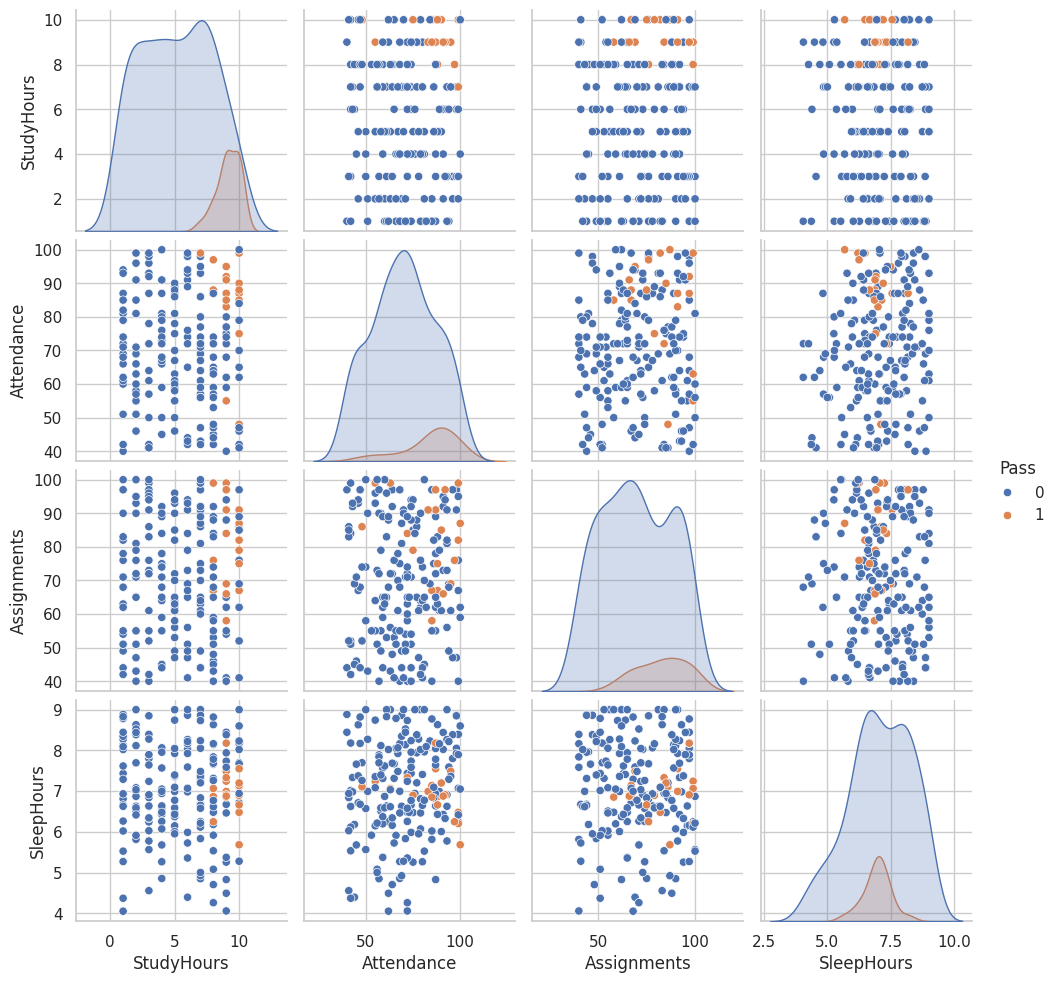

,Accuracy,F1,CV_F1,AUC,Preds,Proba
Model,,,,,,
Logistic Regression,0.96,0.750000,0.393333,0.991111,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, ...","[0.030510816925349835, 0.05169467262719834, 0...."
Bagging,0.96,0.750000,0.493333,0.995556,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, ...","[0.0, 0.3, 0.0, 0.0, 0.006666666666666667, 0.0..."
Decision Tree,0.92,0.600000,0.280000,0.777778,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
AdaBoost,0.92,0.600000,0.648485,0.973333,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, ...","[0.19972611607323912, 0.2775445421123294, 0.25..."
Random Forest,0.94,0.571429,0.446667,1.000000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, ...","[0.005, 0.245, 0.0, 0.0, 0.0, 0.0, 0.015, 0.13..."


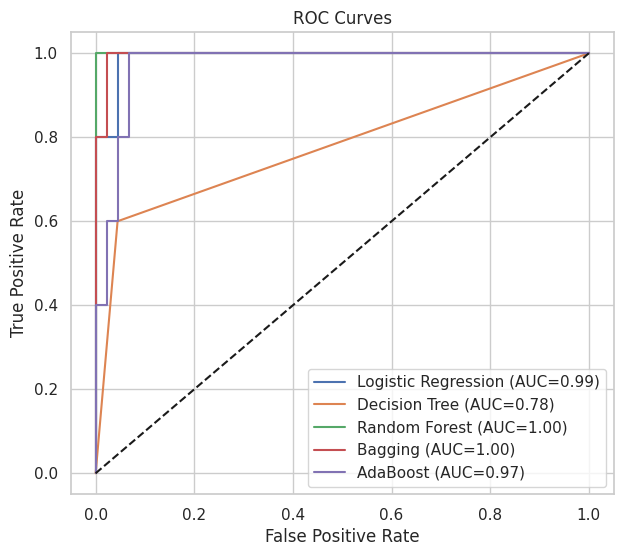

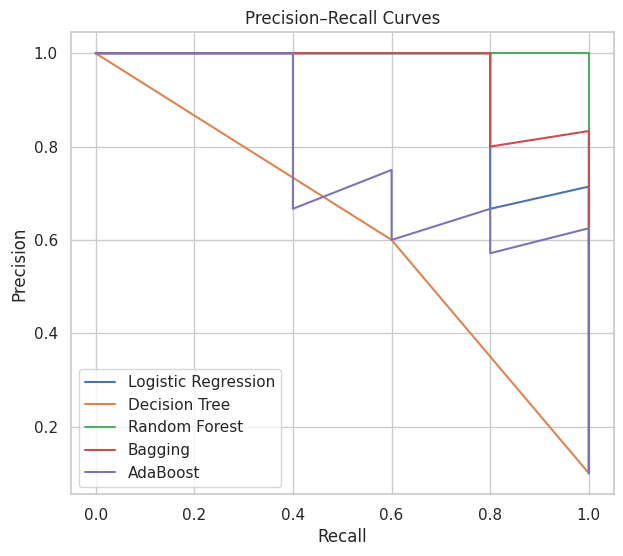

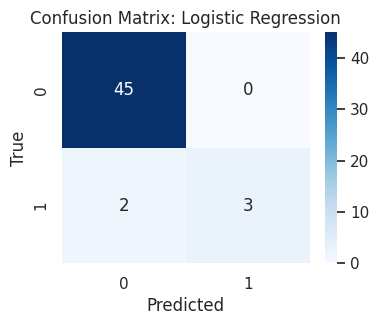

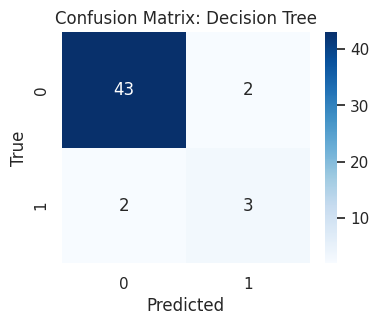

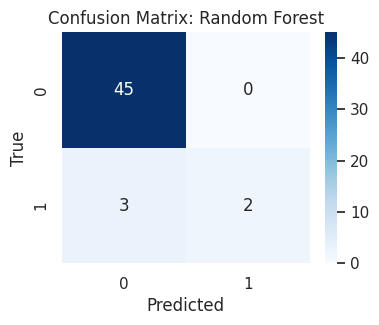

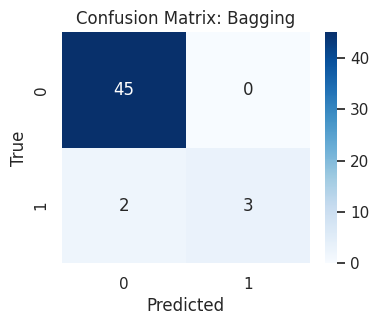

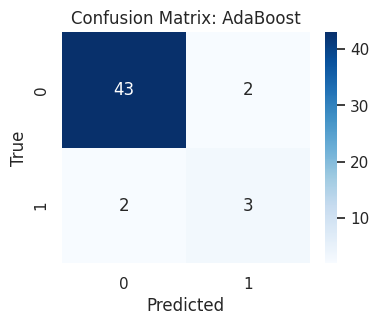

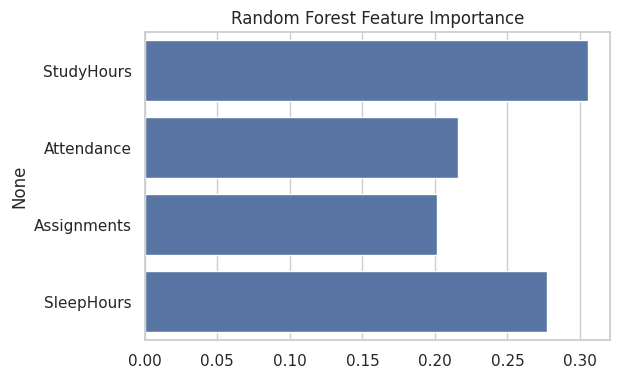

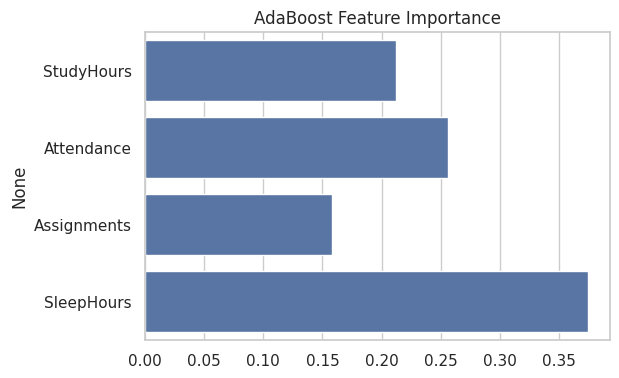


Best Random Forest Params: {'clf__max_depth': 5, 'clf__n_estimators': 100}
Best CV F1: 0.5599999999999999

 Best Performing Model: Logistic Regression
Accuracy                                                 0.96
F1                                                       0.75
CV_F1                                                0.393333
AUC                                                  0.991111
Preds       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, ...
Proba       [0.030510816925349835, 0.05169467262719834, 0....
Name: Logistic Regression, dtype: object


In [1]:
# ===================================================================
# Ensemble Learning — Professional Notebook (with CV + Tuning + Plots)
# ===================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import (
    train_test_split, cross_val_score, GridSearchCV, KFold
)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score,
    roc_curve, precision_recall_curve,
    confusion_matrix, classification_report
)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
)

sns.set(style="whitegrid")
np.random.seed(42)

# -------------------------------------------------------------
# 1. Dataset Generation
# -------------------------------------------------------------
# Create a synthetic dataset with the following features:
# - StudyHours: Time spent on studying (1-10 hours).
# - Attendance: Class attendance percentage (40%-100%).
# - Assignments: Percentage completion of assignments (40%-100%).
# - SleepHours: Average sleep duration (clipped to [4, 9] hours).
# The target variable 'Pass' is determined by a logistic function of these variables.

n = 200
StudyHours = np.random.randint(1, 11, n)
Attendance = np.random.randint(40, 101, n)
Assignments = np.random.randint(40, 101, n)
SleepHours = np.random.normal(7, 1.2, n).clip(4, 9)

score = (
    0.4 * StudyHours +
    0.3 * (Attendance / 10) +
    0.2 * (Assignments / 10) -
    0.8 * np.abs(SleepHours - 7)
)

prob = 1 / (1 + np.exp(-0.8 * (score - 7)))
Pass = (prob > 0.5).astype(int)

df = pd.DataFrame({
    "StudyHours": StudyHours,
    "Attendance": Attendance,
    "Assignments": Assignments,
    "SleepHours": SleepHours,
    "Pass": Pass
})

# Quick dataset visualization
sns.pairplot(df, hue="Pass", diag_kind="kde")
plt.show()

# -------------------------------------------------------------
# 2. Split Data (Train and Test sets)
# -------------------------------------------------------------
X = df.drop("Pass", axis=1)
y = df["Pass"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

# -------------------------------------------------------------
# 3. Models and Pipelines
# -------------------------------------------------------------
base_models = {
    "Logistic Regression": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=500))
    ]),

    "Decision Tree": Pipeline([
        ("clf", DecisionTreeClassifier(max_depth=5))
    ]),

    "Random Forest": Pipeline([
        ("clf", RandomForestClassifier(n_estimators=200))
    ]),

    "Bagging": Pipeline([
        ("clf", BaggingClassifier(
            estimator=DecisionTreeClassifier(max_depth=5),
            n_estimators=150
        ))
    ]),

    "AdaBoost": Pipeline([
        ("clf", AdaBoostClassifier(
            estimator=DecisionTreeClassifier(max_depth=2),
            n_estimators=200,
            learning_rate=0.5
        ))
    ])
}

# -------------------------------------------------------------
# 4. K-Fold Cross Validation Function
# -------------------------------------------------------------
cv = KFold(n_splits=5, shuffle=True, random_state=42)

def cross_val_f1(model):
    return cross_val_score(model, X_train, y_train, cv=cv, scoring="f1").mean()

# -------------------------------------------------------------
# 5. Evaluate Models
# -------------------------------------------------------------
def evaluate(model, name):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    proba = model.predict_proba(X_test)[:, 1]

    return {
        "Model": name,
        "Accuracy": accuracy_score(y_test, preds),
        "F1": f1_score(y_test, preds),
        "CV_F1": cross_val_f1(model),
        "AUC": roc_auc_score(y_test, proba),
        "Preds": preds,
        "Proba": proba
    }

results = [evaluate(model, name) for name, model in base_models.items()]
comparison = pd.DataFrame(results).set_index("Model")
display(comparison.sort_values("F1", ascending=False))

# -------------------------------------------------------------
# 6. ROC and PR Curves
# -------------------------------------------------------------
plt.figure(figsize=(7,6))
for r in results:
    fpr, tpr, _ = roc_curve(y_test, r["Proba"])
    plt.plot(fpr, tpr, label=f"{r['Model']} (AUC={r['AUC']:.2f})")
plt.plot([0,1],[0,1],"k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.show()

# Precision-Recall Curve
plt.figure(figsize=(7,6))
for r in results:
    prec, rec, _ = precision_recall_curve(y_test, r["Proba"])
    plt.plot(rec, prec, label=r["Model"])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves")
plt.legend()
plt.show()

# -------------------------------------------------------------
# 7. Confusion Matrix Heatmaps
# -------------------------------------------------------------
def plot_cm(model_name, preds):
    cm = confusion_matrix(y_test, preds)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
    plt.title(f"Confusion Matrix: {model_name}")
    plt.ylabel("True")
    plt.xlabel("Predicted")
    plt.show()

for r in results:
    plot_cm(r["Model"], r["Preds"])

# -------------------------------------------------------------
# 8. Feature Importance (Tree-based models)
# -------------------------------------------------------------
# Random Forest Feature Importance
rf = base_models["Random Forest"]["clf"] if isinstance(base_models["Random Forest"], dict) else RandomForestClassifier()
rf.fit(X_train, y_train)

plt.figure(figsize=(6,4))
sns.barplot(x=rf.feature_importances_, y=X.columns)
plt.title("Random Forest Feature Importance")
plt.show()

# AdaBoost Feature Importance
ada = base_models["AdaBoost"]["clf"]
plt.figure(figsize=(6,4))
sns.barplot(x=ada.feature_importances_, y=X.columns)
plt.title("AdaBoost Feature Importance")
plt.show()

# -------------------------------------------------------------
# 9. Hyperparameter Tuning using GridSearchCV
# -------------------------------------------------------------
param_grid = {
    "clf__n_estimators": [100, 200, 300],
    "clf__max_depth": [None, 5, 10]
}

rf_pipe = Pipeline([("clf", RandomForestClassifier())])

grid = GridSearchCV(
    rf_pipe,
    param_grid,
    cv=cv,
    scoring="f1",
    n_jobs=-1
)

grid.fit(X_train, y_train)
print("\nBest Random Forest Params:", grid.best_params_)
print("Best CV F1:", grid.best_score_)

# -------------------------------------------------------------
# 10. Final Best Model Summary
# -------------------------------------------------------------
best = comparison.sort_values("F1", ascending=False).iloc[0]
print("\n Best Performing Model:", best.name)
print(best)
